Attempting to isolate data from Rob's analysis that might be useful for the Salish Sea model.

**Plan**

Compare monthly temperature/salinity profile in the mouth of Juan de Fuca between observations and model boundary conditions. 

In [29]:
import ACTDR

import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
from salishsea_tools import viz_tools, nc_tools
import seaborn as sns
import datetime

In [30]:
ACTDR.load_dat('JuandeFucaMouth.dat')

> open  JuandeFucaMouth.dat
> load CTD_DAT
> load STANDARD_KEYS
> close  JuandeFucaMouth.dat
> complete


In [31]:
b = '/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc'
grid_B = nc.Dataset(b)
bathy = grid_B.variables['Bathymetry'][:]
lat=grid_B.variables['nav_lat'][:]
lon=grid_B.variables['nav_lon'][:]


In [32]:
%matplotlib inline

In [33]:
sns.set_style("darkgrid")

<matplotlib.contour.QuadContourSet instance at 0x7ff65be368c0>

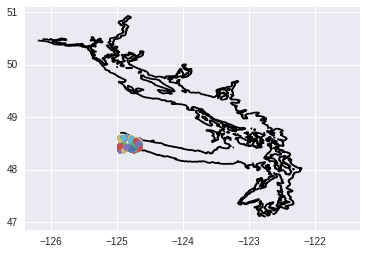

In [34]:
fig,ax=plt.subplots(1,1)
for cast in ACTDR.CTD_DAT:
    ax.plot(cast['Longitude'], cast['Latitude'], 'o' )
viz_tools.plot_coastline(ax,grid_B,coords='map')

In [35]:
cast=ACTDR.CTD_DAT[0]
print cast.keys()

['Temperature', 'Longitude', 'Month', 'Depth', 'Year', 'Latitude', 'ID', 'Salinity', 'Day']


Use pandas to help manipulate the data

In [36]:
import pandas as pd

# Manipulating the Observed Data

In the next few cells, I will familiarize myself with the data and how to handle it

In [37]:
data = pd.DataFrame(ACTDR.CTD_DAT)

Histogram by year

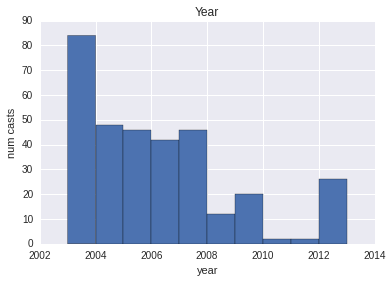

In [38]:
data.hist('Year')
plt.ylabel('num casts')
plt.xlabel('year')
ax=plt.gca()
ax.get_xaxis().get_major_formatter().set_useOffset(False)

In [39]:
data['Year'].max()

2013

Why isn't there any 2014 data? Did the create_JuandeFuca.py exlude it because of anomalies? Or maybe it wasn't in my defined area.

## Depth between 200 and 300m

This seems like a reasonable first attempt at elimintating data the isnt't near the open boundary

In [40]:


#remove data if max depth is smaller than 200 and bigger than 300
data_dep200to300 = data[(data['Depth'].apply(max)>200) & (data['Depth'].apply(max)<300)]


In [41]:
def plot_grouped_data(data,key, field,xmin=-126,xmax=-124,ymin=48,ymax=49,zmin=0,zmax=300,vmin=28,vmax=34):
    """Groups the data based on key. Then plots the field of the grouped data over depth
    Examples: plot_grouped_data(data,'Month','Salinity')"""
    
    group = data.groupby(key)
    num=group.ngroups
    fig,axs = plt.subplots(2,num,figsize=(15,8))
    for ind,ax, axm in zip(group.groups.keys(),axs[0,:],axs[1,:]):
        dat = group.get_group(ind)
        for dep,var,lon,lat in zip(dat['Depth'], dat[field],dat['Longitude'],dat['Latitude']):
            ax.plot(var,dep)
            axm.plot(lon,lat,'o')
        ax.set_title('{}: {}'.format(key, ind))
        ax.set_ylim([zmax,zmin])
        ax.set_xlim([vmin,vmax])
        ax.set_xlabel(field)
        ax.set_ylabel('Depth [m]')
        #map
        viz_tools.plot_coastline(axm,grid_B,coords='map')
        axm.set_ylim([ymin,ymax])
        axm.set_xlim([xmin,xmax])

##Group by Year

Look at the coverage of data in each year

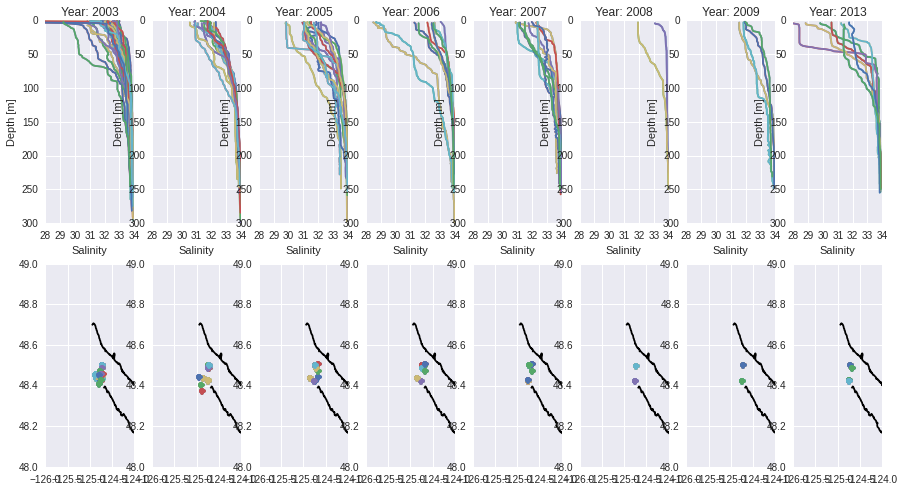

In [42]:
fig = plot_grouped_data(data_dep200to300,'Year','Salinity')

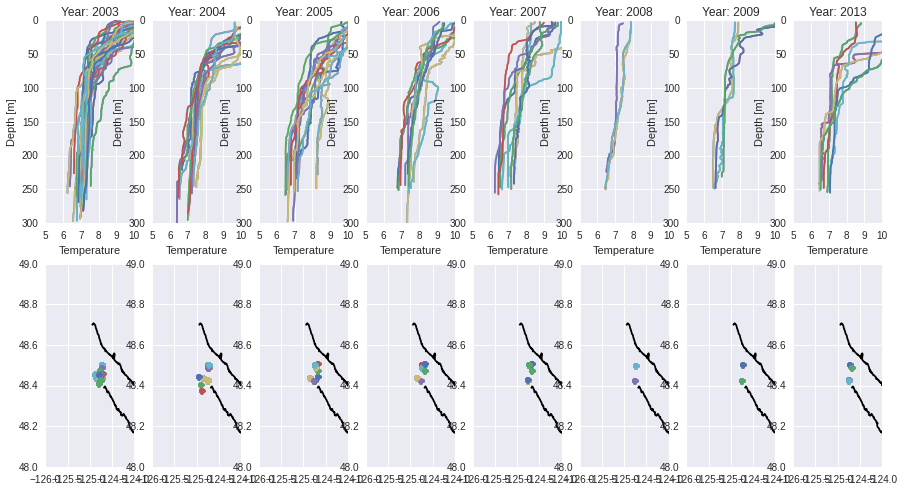

In [43]:
fig = plot_grouped_data(data_dep200to300,'Year','Temperature',vmin=5,vmax=10)

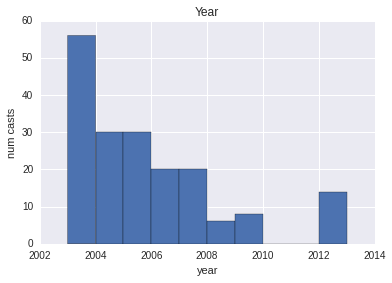

In [44]:
data_dep200to300.hist('Year')
plt.ylabel('num casts')
plt.xlabel('year')
ax=plt.gca()
ax.get_xaxis().get_major_formatter().set_useOffset(False)

##Group by Month

Look at the coverage of data in each month

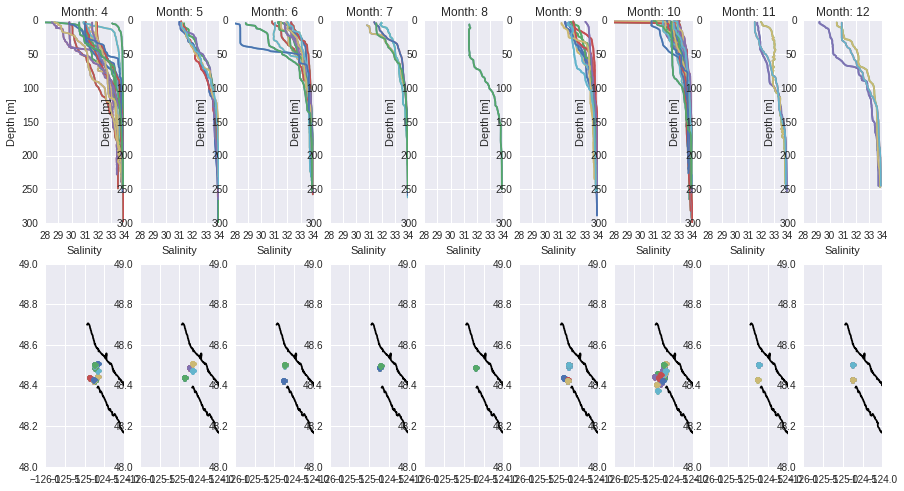

In [45]:
fig = plot_grouped_data(data_dep200to300,'Month','Salinity')

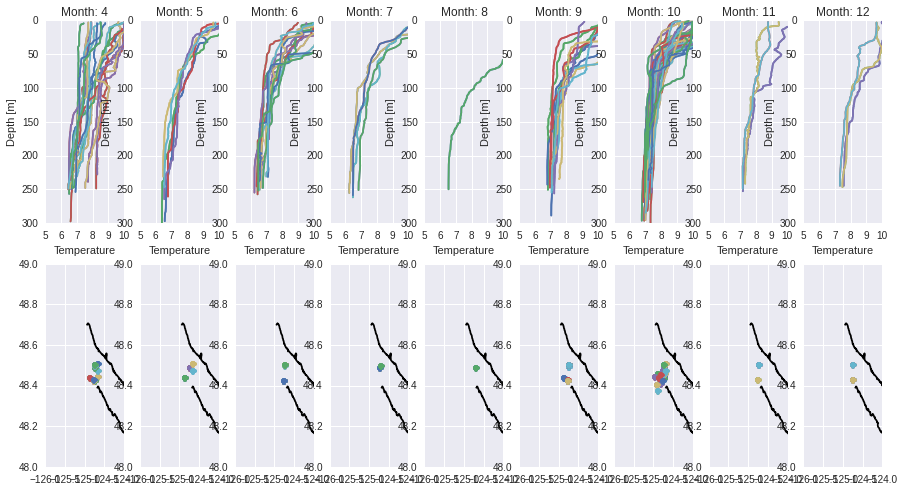

In [46]:
fig = plot_grouped_data(data_dep200to300,'Month','Temperature', vmin=5,vmax=10)

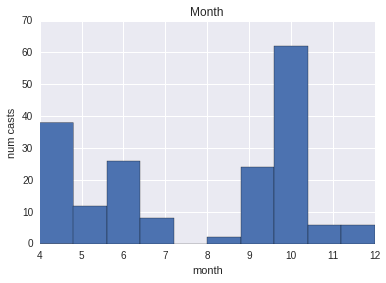

In [47]:
data_dep200to300.hist('Month')
plt.ylabel('num casts')
plt.xlabel('month')

## Max Salinity range of Observations


In [48]:
print 'Highest maximum salinity in all of the casts {0:.3}'.format(max(data_dep200to300['Salinity'].apply(max)))
print 'Lowest maximum salinity in all of the casts: {0:.3}'.format(min(data_dep200to300['Salinity'].apply(max)))
print 'Mean maximum salinity in all of the casts {0:.3}'.format(np.mean(data_dep200to300['Salinity'].apply(max)))

Highest maximum salinity in all of the casts 34.0
Lowest maximum salinity in all of the casts: 33.5
Mean maximum salinity in all of the casts 33.9


# Model boundary conditions

Start to look at the model boundary conditions.

In each month, plot the salinity/temperature at a few points along the open boundary. Include on the same axis the observations.

In [49]:
#Loading boundary conditions
bc = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/open_boundaries/west/SalishSea2_Masson_DC.nc')
nc_tools.show_variables(bc)

[u'deptht', u'nav_lat', u'nav_lon', u'nbidta', u'nbjdta', u'nbrdta', u'time_counter', u'vosaline', u'votemper']


## Selection of observations
Remove observations with longitude < -124.8 to exclude points far from observations. Check histogram again.

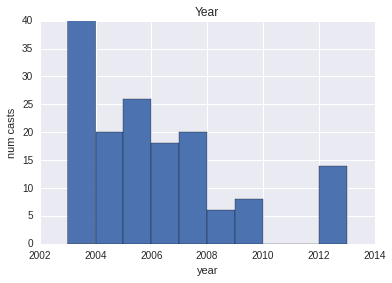

In [50]:
data_compare = data_dep200to300[data_dep200to300['Longitude'] > -124.8]
data_compare.hist('Year')
plt.ylabel('num casts')
plt.xlabel('year')
ax=plt.gca()
ax.get_xaxis().get_major_formatter().set_useOffset(False)

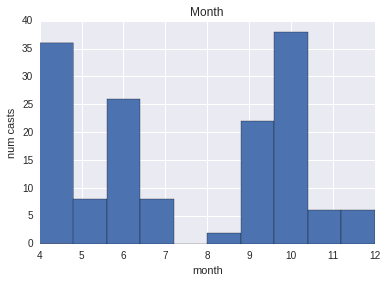

In [51]:
data_compare.hist('Month')
plt.ylabel('num casts')
plt.xlabel('month')

### plotting function

In [52]:
def compare_bc_obs(month, indices, field, data_obs, bcs,
                   xmin=-125,xmax=-124,ymin=48,ymax=49,zmin=0,zmax=300, vmin=29,vmax=35 ):
    """Compares the observations from IOS/NOAA data near the mouth of Juan de Fuca with model boundary conditions.
    Comparisons are during month and at open boundary indices.
    Field is compared ('Temperature' or 'Salinity' )
    Observations stored in data_obs (DataFrame)
    Model bcs stored in bcs (netcdf handle)"""
    
    salinity_flag = False #Print extra stuff if we are looking at salinity
    fig, [ax, axm] = plt.subplots(1,2,figsize=(10,3))
    #lists to store maxes of observations and model
    max_obs=[]
    max_bcs=[]
    
    #Model variables
    time = bcs.variables['time_counter']
    depth = bcs.variables['deptht']
    lats= bcs.variables['nav_lat']
    lons = bcs.variables['nav_lon']
    if field == 'Salinity':
        var = bcs.variables['vosaline']
        salinity_flag=True
    elif field == 'Temperature':
        var = bcs.variables['votemper']
    #times convert to date time
    start = datetime.datetime(2014,1,1) #arbitrary year.
    dates = [ start + datetime.timedelta(days = 7*t) for t in time]
    #Look up model dates in the desired month
    t_inds = []; 
    for t,d in enumerate(dates):
        if d.month == month:
            t_inds.append(t)
    
    #plotting
    #plot model
    for i in indices: #iterate through space index
        for t in t_inds: #iterate through time index
            ax.plot( var[t,:,0,i],depth[:],'-ob',label='model')
            max_bcs.append(np.nanmax(var[t,:,0,i]))
        #location on map
        axm.plot(lons[0,indices],lats[0,indices],'ob',label='model')
    
    #plot obs
    data_m = data_obs[data_obs['Month']==month]
    for dep, var_obs, lon, lat in zip(data_m['Depth'],data_m[field], data_m['Longitude'], data_m['Latitude']):
        ax.plot(var_obs, dep,'-*r',label = 'obs',alpha=0.1)
        max_obs.append(np.nanmax(var_obs))
        #plot location on map
        axm.plot(lon,lat,'*r',label='obs')
    ax.set_ylim([zmax,zmin])
    ax.set_xlim([vmin,vmax])
    ax.set_title('Month {}'.format(month))
    ax.set_ylabel('Depth [m]')
    ax.set_xlabel(field)

    
    #plotmap
    viz_tools.plot_coastline(axm,grid_B,coords='map')
    axm.set_ylim([ymin,ymax])
    axm.set_xlim([xmin,xmax])
    
    #fake the legend
    simObs, = axm.plot(0,0,'r*')
    simMod, = axm.plot(0,0,'bo')
    axm.legend([simObs,simMod], ['obs','model'])
    #Maxes of obs/model
    max_obs_max = np.nanmax(max_obs)
    min_obs_max = np.nanmin(max_obs)
    max_bcs_max = np.nanmean(max_bcs)
    if salinity_flag:
        axm.text(xmin+0.1,ymin+.25,'Max of obs maxes {0:.4}'.format(max_obs_max))
        axm.text(xmin+0.1,ymin+.15,'Min of obs maxes {0:.4}'.format(min_obs_max))
        axm.text(xmin+0.1,ymin+.05,'Max of model maxes {0:.4}'.format(max_bcs_max))
    
    return fig, max_obs_max, min_obs_max, max_bcs_max


## Salinity
Month by month salinity comparisons

Mean difference between model max and observed max: -0.4841
Mean difference between model max and minimum of observed max: -0.3095
Max difference between model max and observed max: -0.2949
Max difference between model max and minimum of observed max: -0.1119
Min difference between model max and observed max: -0.7103
Min difference between model max and minimum of observed max: -0.5253


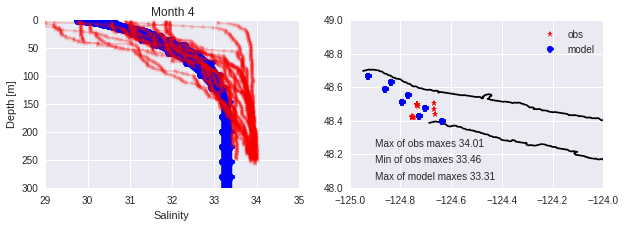

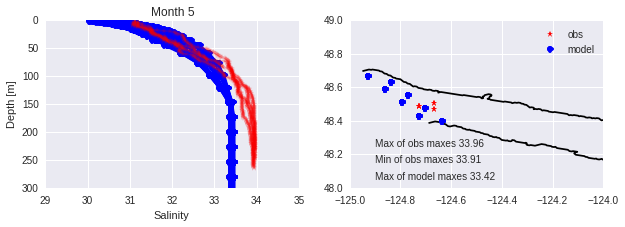

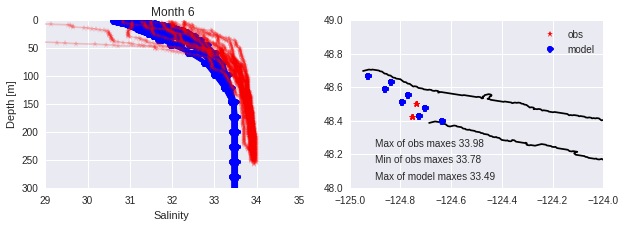

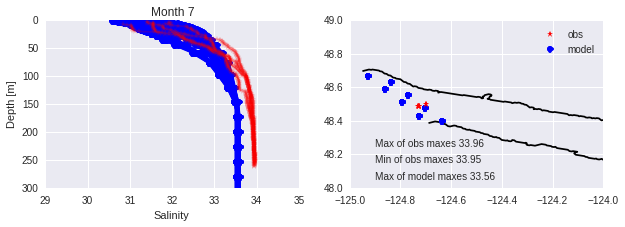

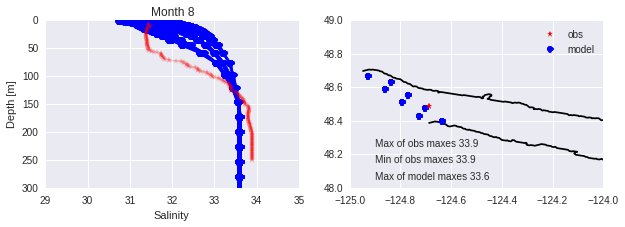

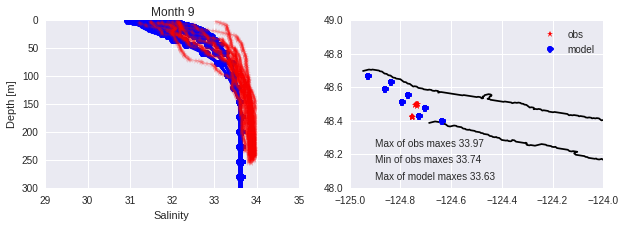

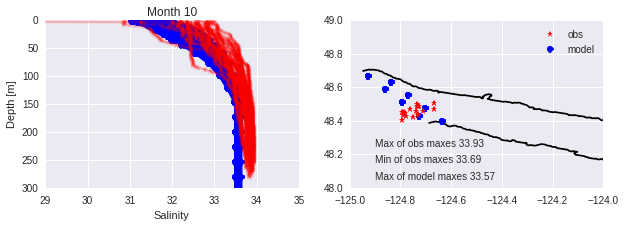

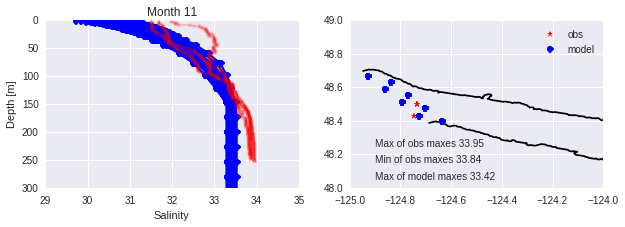

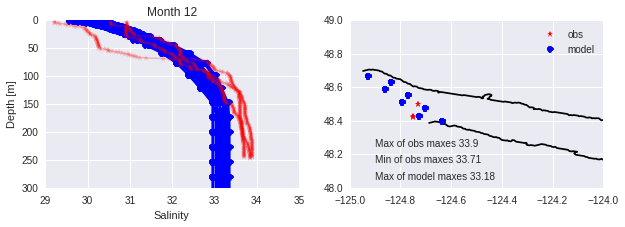

In [53]:
maxes_obs =[] #list for the maximum of the observed maxes in each month
mins_obs = [] #list for the minumum of the observed maxes in each month
maxes_model = [] #list for the maximum of the model maxes in each month


locs = [20,40,60,80,790,810,830,850] # indices of boundary conditions to use in comparison
grouped=data_compare.groupby('Month')
for m in grouped.groups.keys():
    fig, max_obs_max, min_obs_max, max_bcs_max = compare_bc_obs(m,locs,'Salinity',data_compare,bc)
    maxes_obs.append(max_obs_max)
    mins_obs.append(min_obs_max)
    maxes_model.append(max_bcs_max)
maxes_model = np.array(maxes_model)
mins_obs = np.array(mins_obs)
maxes_obs = np.array(maxes_obs)
print 'Mean difference between model max and observed max: {0:.4}'.format(np.mean(maxes_model-maxes_obs))
print 'Mean difference between model max and minimum of observed max: {0:.4}'.format(np.mean(maxes_model-mins_obs))
print 'Max difference between model max and observed max: {0:.4}'.format(np.max(maxes_model-maxes_obs))
print 'Max difference between model max and minimum of observed max: {0:.4}'.format(np.max(maxes_model-mins_obs))
print 'Min difference between model max and observed max: {0:.4}'.format(np.min(maxes_model-maxes_obs))
print 'Min difference between model max and minimum of observed max: {0:.4}'.format(np.min(maxes_model-mins_obs))

* Generally, model is too fresh in the deep. More summary below.

### Montly max observed and modelled salinities

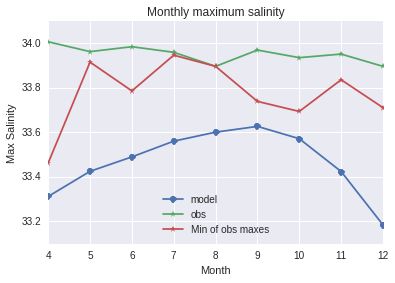

In [54]:
months = grouped.groups.keys()
plt.plot(months,maxes_model,'o-',label='model')
plt.plot(months, maxes_obs,'*-',label='obs')
plt.plot(months, mins_obs,'*-',label='Min of obs maxes')
ax=plt.gca()
ax.set_xlabel('Month')
ax.set_ylabel('Max Salinity')
ax.set_title('Monthly maximum salinity')
ax.legend(loc=0)

* Hmm, strong seasonal trend in model max salinty but not in the observations. Why?
* Are there enough observations in each month to see a significant seasonsal trend?
* There is more variability in the observed minimum of the max salinities.

## Temperature
Month by month temperature comparisons

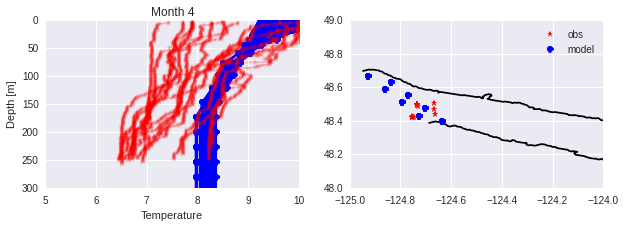

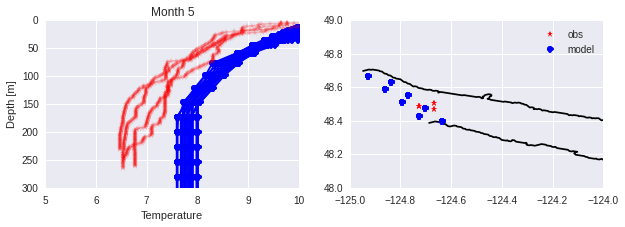

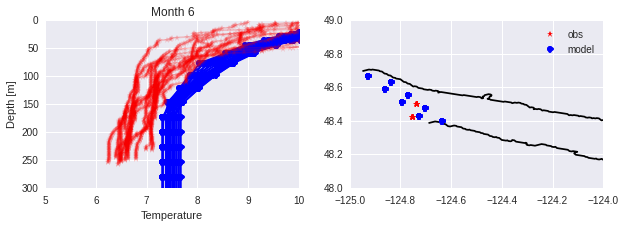

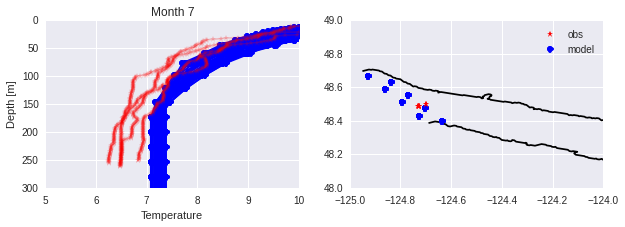

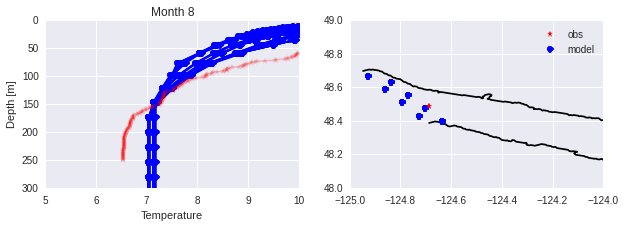

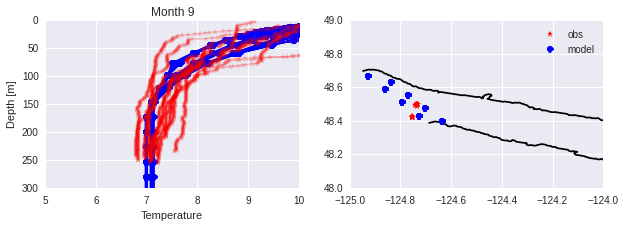

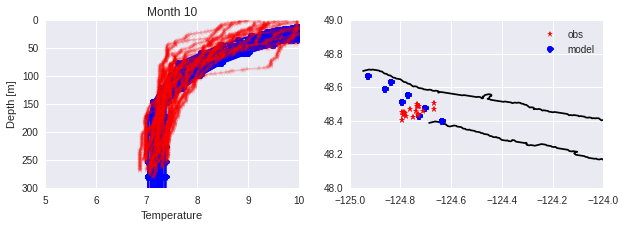

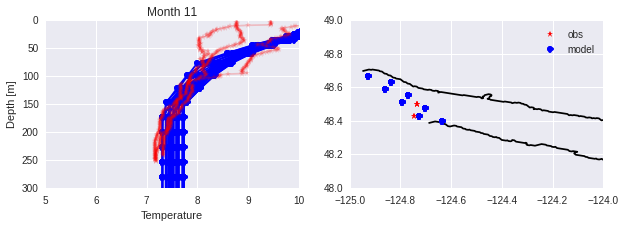

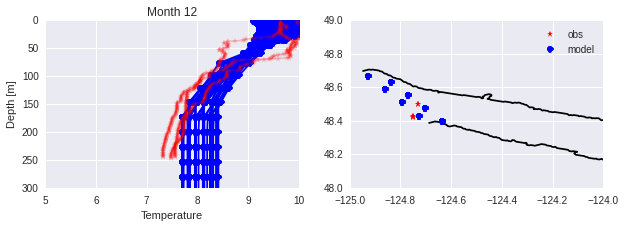

In [55]:
grouped=data_compare.groupby('Month')
for m in grouped.groups.keys():
    fig = compare_bc_obs(m,locs,'Temperature',data_compare,bc,vmin=5,vmax=10)

#Summary

### Salinity
* Boundary condition at depth is fresher than all of the observations. 
* Degree of freshness varies with the season. 
* Mean difference in max salinities is ~0.5 (model fresher)
* Max difference in max salinities is ~0.7 
* Min difference in max salinities is ~0.3
* Is that significant?
   * Our spin up deep water renewal is about 0.2 psu too fresh (assumuing 31 is the target). I think part of that can be explained by the bcs. I need to dig into literature about the density of the upwelled coastal waters entering the system and its effect on the deep water renewal. I think I recall reading a Masson paper about this. T
   * I'm interested in seeing how salty our nowcast deep water renewal will be and when it will happen. I wonder if there is a threshold for density of bcs in order to observe renewal. Something to play with...
   * Will this year's DWR be about the same salinity as spin up, even though the salinity of the Haro Strait waters is much fresher than the spin up year?
   * Our intermediate SoG is too fresh and I don't think salinty of the incoming waters really affects that. There is still too much mixing there, but it may be linked to the background rate. I think this because the SoG intermadiate waters are much tamer in terms of mixing than the Haro Strait waters. So, I think the mixing there is mostly diffusion, which would be determined by our background value. Mixing in the surface SoG is driven by wind so that is different. 

### Temperature

* Temperature is a lot more variable, but in the deep, the trend looks that the model is warmer. 
* Deep fall temperatures look good.

# Questions and Next Steps

* More reading about deep water renewal and denisty of upwelled waters
* Do I have enough data to make a conclusion about the saltiness of the bcs? Ie.
* Is it better to just reduce mixing to get the salitier dwr or to come up with saltier bcs?
* Would a 0.5 increase in psu at the open boundary make a difference? Perhaps something to test in small domain, but I need to reexamine if I get deep water renwal there. Year long sim?